#  ***STEP 1: Import libraries***

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.filters import threshold_otsu, threshold_sauvola


# ***STEP 2: Dataset path & structure check***

In [2]:
DATASET_PATH_SEG = "/kaggle/input/datasets/atikaakter11/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset"

IMG_PATH = os.path.join(DATASET_PATH_SEG, "image")
MASK_PATH = os.path.join(DATASET_PATH_SEG, "mask")

print("Main folders:", os.listdir(DATASET_PATH_SEG))
print("Image folders:", os.listdir(IMG_PATH))
print("Mask folders:", os.listdir(MASK_PATH))


Main folders: ['mask', 'image']
Image folders: ['2', '0', '3', '1']
Mask folders: ['2', '0', '3', '1']


# ***STEP 3: Dataset summary (images per class)***



In [3]:
def segmentation_summary(dataset_path):
    image_path = os.path.join(dataset_path, "image")
    mask_path = os.path.join(dataset_path, "mask")

    classes = sorted(os.listdir(image_path))
    print("\nDataset Summary:\n")

    for cls in classes:
        num_images = len(os.listdir(os.path.join(image_path, cls)))
        num_masks = len(os.listdir(os.path.join(mask_path, cls)))
        print(f"Class '{cls}': {num_images} images | {num_masks} masks")

segmentation_summary(DATASET_PATH_SEG)



Dataset Summary:

Class '0': 1595 images | 1595 masks
Class '1': 649 images | 650 masks
Class '2': 999 images | 1000 masks
Class '3': 994 images | 994 masks


# ***STEP 4: Define Metrics (Dice & Jaccard))***

In [4]:
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-8)

def jaccard_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + 1e-8)


# ***STEP 5: Apply to ENTIRE Dataset***

In [5]:
dice_otsu_all = []
dice_sauvola_all = []
iou_otsu_all = []
iou_sauvola_all = []

categories = sorted(os.listdir(IMG_PATH))

for cat in categories:

    img_folder = os.path.join(IMG_PATH, cat)
    mask_folder = os.path.join(MASK_PATH, cat)

    img_files = sorted(os.listdir(img_folder))

    for img_name in img_files:

        img_path = os.path.join(img_folder, img_name)
        mask_path = os.path.join(mask_folder, img_name)

        if not os.path.exists(mask_path):
            continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            continue

        img = cv2.resize(img, (256,256))
        mask = cv2.resize(mask, (256,256))

        gt = (mask > 0).astype(np.uint8)

        img_blur = cv2.GaussianBlur(img, (5,5), 0)

        # OTSU
        otsu_mask = (img_blur > threshold_otsu(img_blur)).astype(np.uint8)

        # SAUVOLA
        img_float = img_blur.astype(np.float32) / 255.0
        sauvola_thresh = threshold_sauvola(img_float, window_size=25)
        sauvola_mask = (img_float > sauvola_thresh).astype(np.uint8)

        dice_otsu_all.append(dice_score(gt, otsu_mask))
        dice_sauvola_all.append(dice_score(gt, sauvola_mask))

        iou_otsu_all.append(jaccard_score(gt, otsu_mask))
        iou_sauvola_all.append(jaccard_score(gt, sauvola_mask))


# ***STEP 6: Print Final Average Result***

In [6]:
print("\n===== FINAL RESULTS ON FULL DATASET =====")
print("Otsu Dice:", np.mean(dice_otsu_all))
print("Sauvola Dice:", np.mean(dice_sauvola_all))
print("Otsu Jaccard:", np.mean(iou_otsu_all))
print("Sauvola Jaccard:", np.mean(iou_sauvola_all))



===== FINAL RESULTS ON FULL DATASET =====
Otsu Dice: 0.07340904993687636
Sauvola Dice: 0.04386979926547169
Otsu Jaccard: 0.0381030804356634
Sauvola Jaccard: 0.022426829895575737


# ***Step 7: Visualization of Thresholding Results per Category***


Category 0
Otsu     -> Dice: 0.0 | Jaccard: 0.0
Sauvola  -> Dice: 0.0 | Jaccard: 0.0

Category 1
Otsu     -> Dice: 0.1177 | Jaccard: 0.0625
Sauvola  -> Dice: 0.0651 | Jaccard: 0.0336

Category 2
Otsu     -> Dice: 0.0498 | Jaccard: 0.0255
Sauvola  -> Dice: 0.0371 | Jaccard: 0.0189

Category 3
Otsu     -> Dice: 0.0254 | Jaccard: 0.0129
Sauvola  -> Dice: 0.0201 | Jaccard: 0.0102


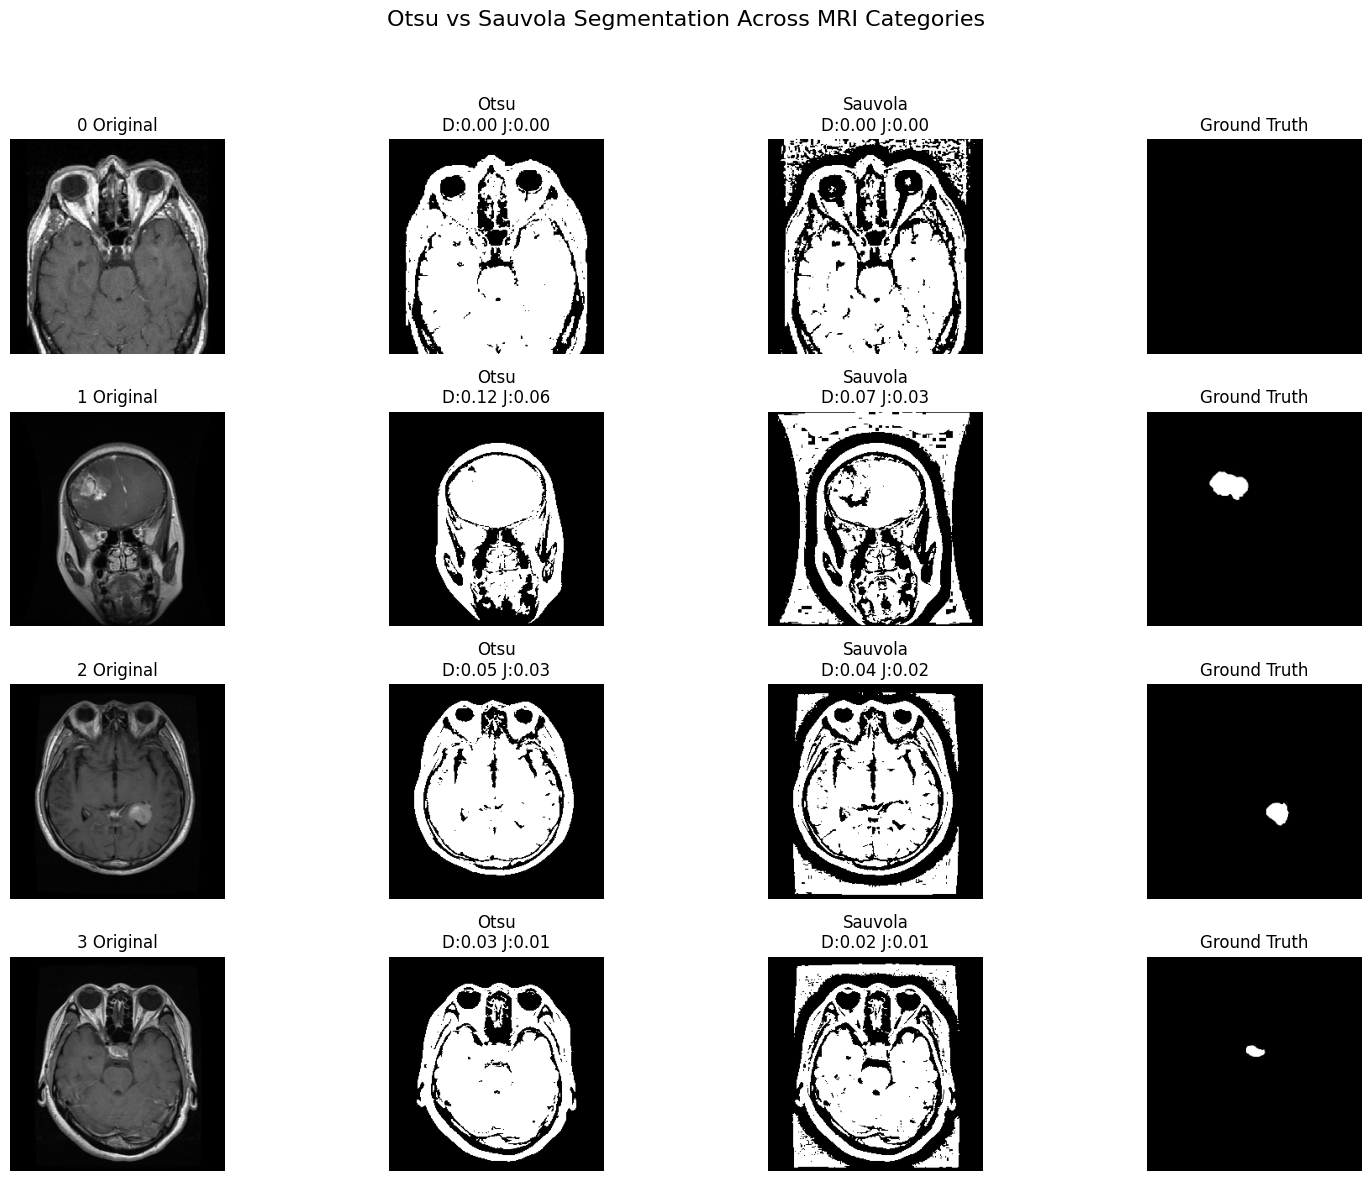

In [7]:
categories = ["0", "1", "2", "3"]

IMG_PATH = os.path.join(DATASET_PATH_SEG, "image")
MASK_PATH = os.path.join(DATASET_PATH_SEG, "mask")

plt.figure(figsize=(16, 12))

for i, cat in enumerate(categories):

    img_folder = os.path.join(IMG_PATH, cat)
    mask_folder = os.path.join(MASK_PATH, cat)

    img_files = sorted(os.listdir(img_folder))
    mask_files = sorted(os.listdir(mask_folder))

    img_path = os.path.join(img_folder, img_files[0])
    mask_path = os.path.join(mask_folder, mask_files[0])

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    # Convert mask to binary
    gt = (mask > 0).astype(np.uint8)

    # OTSU
    otsu_thresh = threshold_otsu(img)
    otsu_mask = (img > otsu_thresh).astype(np.uint8)

    # SAUVOLA
    sauvola_thresh = threshold_sauvola(img, window_size=25, k=0.2)
    sauvola_mask = (img > sauvola_thresh).astype(np.uint8)

    # ----- METRICS -----
    dice_otsu = dice_score(gt, otsu_mask)
    dice_sauvola = dice_score(gt, sauvola_mask)

    jac_otsu = jaccard_score(gt, otsu_mask)
    jac_sauvola = jaccard_score(gt, sauvola_mask)

    print(f"\nCategory {cat}")
    print("Otsu     -> Dice:", round(dice_otsu,4),
          "| Jaccard:", round(jac_otsu,4))
    print("Sauvola  -> Dice:", round(dice_sauvola,4),
          "| Jaccard:", round(jac_sauvola,4))

    # ----- PLOTS -----
    plt.subplot(4, 4, i*4 + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{cat} Original")
    plt.axis("off")

    plt.subplot(4, 4, i*4 + 2)
    plt.imshow(otsu_mask, cmap="gray")
    plt.title(f"Otsu\nD:{dice_otsu:.2f} J:{jac_otsu:.2f}")
    plt.axis("off")

    plt.subplot(4, 4, i*4 + 3)
    plt.imshow(sauvola_mask, cmap="gray")
    plt.title(f"Sauvola\nD:{dice_sauvola:.2f} J:{jac_sauvola:.2f}")
    plt.axis("off")

    plt.subplot(4, 4, i*4 + 4)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

plt.suptitle("Otsu vs Sauvola Segmentation Across MRI Categories", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
